In [ ]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import  DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('diabetic_data.csv')
data.head(2).T

,0,1
encounter_id,2278392,149190
patient_nbr,8222157,55629189
race,Caucasian,Caucasian
gender,Female,Female
age,[0-10),[10-20)
weight,?,?
admission_type_id,6,1
discharge_disposition_id,25,1
admission_source_id,1,7
time_in_hospital,1,3


In [ ]:
print(np.unique(data['age']))

replaceDict = {'[0-10)' : 5,
'[10-20)' : 15,
'[20-30)' : 25, 
'[30-40)' : 35, 
'[40-50)' : 45, 
'[50-60)' : 55,
'[60-70)' : 65, 
'[70-80)' : 75,
'[80-90)' : 85,
'[90-100)' : 95}

data['age'] = data['age'].apply(lambda x : replaceDict[x])
print(data['age'].head())

['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
0     5
1    15
2    25
3    35
4    45
Name: age, dtype: int64


In [ ]:
data.dropna(inplace = True)
print('Total data = ', len(data))
print('Unique entries = ', len(np.unique(data['patient_nbr'])))
data.drop_duplicates(['patient_nbr'], keep = 'first', inplace = True)
print('Length after removing Duplicates:', len(data))

Total data =  101766
Unique entries =  71518
Length after removing Duplicates: 71518


In [ ]:
t = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])
for col in data.columns :
    lenn = len(data[data[col] == '?'])
    t.add_row([col,lenn,lenn / len(data)])
print(t)

+--------------------------+----------------+-----------------------+
|       Column Name        | Missing Values |   Missing Percentage  |
+--------------------------+----------------+-----------------------+
|       encounter_id       |       0        |          0.0          |
|       patient_nbr        |       0        |          0.0          |
|           race           |      1948      |  0.027237898151514305 |
|          gender          |       0        |          0.0          |
|           age            |       0        |          0.0          |
|          weight          |     68665      |   0.960107944853044   |
|    admission_type_id     |       0        |          0.0          |
| discharge_disposition_id |       0        |          0.0          |
|   admission_source_id    |       0        |          0.0          |
|     time_in_hospital     |       0        |          0.0          |
|        payer_code        |     31043      |   0.434058558684527   |
|    medical_special

In [ ]:
high_frequency = ['InternalMedicine', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Orthopedics-Reconstructive', 
                 'Emergency/Trauma', 'Urology','ObstetricsandGynecology','Psychiatry','Pulmonology ','Nephrology','Radiologist']

low_frequency = ['Surgery-PlasticwithinHeadandNeck','Psychiatry-Addictive','Proctology','Dermatology','SportsMedicine','Speech','Perinatology',\
                'Neurophysiology','Resident','Pediatrics-Hematology-Oncology','Pediatrics-EmergencyMedicine','Dentistry','DCPTEAM','Psychiatry-Child/Adolescent',\
                'Pediatrics-Pulmonology','Surgery-Pediatric','AllergyandImmunology','Pediatrics-Neurology','Anesthesiology','Pathology','Cardiology-Pediatric',\
                'Endocrinology-Metabolism','PhysicianNotFound','Surgery-Colon&Rectal','OutreachServices',\
                'Surgery-Maxillofacial','Rheumatology','Anesthesiology-Pediatric','Obstetrics','Obsterics&Gynecology-GynecologicOnco']

pediatrics = ['Pediatrics','Pediatrics-CriticalCare','Pediatrics-EmergencyMedicine','Pediatrics-Endocrinology','Pediatrics-Hematology-Oncology',\
               'Pediatrics-Neurology','Pediatrics-Pulmonology', 'Anesthesiology-Pediatric', 'Cardiology-Pediatric', 'Surgery-Pediatric']

psychic = ['Psychiatry-Addictive', 'Psychology', 'Psychiatry',  'Psychiatry-Child/Adolescent', 'PhysicalMedicineandRehabilitation', 'Osteopath']


neurology = ['Neurology', 'Surgery-Neuro',  'Pediatrics-Neurology', 'Neurophysiology']


surgery = ['Surgeon', 'Surgery-Cardiovascular', \
          'Surgery-Cardiovascular/Thoracic', 'Surgery-Colon&Rectal', 'Surgery-General', 'Surgery-Maxillofacial', \
             'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck',  'Surgery-Thoracic',\
             'Surgery-Vascular', 'SurgicalSpecialty', 'Podiatry']
             
ungrouped = ['Endocrinology','Gastroenterology','Gynecology','Hematology','Hematology/Oncology','Hospitalist','InfectiousDiseases',\
           'Oncology','Ophthalmology','Otolaryngology','Pulmonology','Radiology']


missing = ['?']

colMedical = []

for val in data['medical_specialty'] :
    if val in pediatrics :
        colMedical.append('pediatrics')
    elif val in psychic :
        colMedical.append('psychic')
    elif val in neurology :
        colMedical.append('neurology')
    elif val in surgery :
        colMedical.append('surgery')
    elif val in high_frequency :
        colMedical.append('high_freq')
    elif val in low_frequency :
        colMedical.append('low_freq')
    elif val in ungrouped :
        colMedical.append('ungrouped')
    elif val in missing :
        colMedical.append('missing')

data['medical_specialty'] = colMedical

In [ ]:
diag_1 = Counter(list(data['diag_1'])).most_common(1)[0][0]
diag_2 = Counter(list(data['diag_2'])).most_common(1)[0][0]
diag_3 = Counter(list(data['diag_3'])).most_common(1)[0][0]

data['diag_1'] = data['diag_1'].apply(lambda x : diag_1 if x == '?' else x)
data['diag_2'] = data['diag_1'].apply(lambda x : diag_2 if x == '?' else x)
data['diag_3'] = data['diag_3'].apply(lambda x : diag_3 if x == '?' else x)

In [ ]:
print(len(np.unique(data['diag_1'])))  
print(len(np.unique(data['diag_2'])))  
print(len(np.unique(data['diag_3'])))  

data['diag_1'] = data['diag_1'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

data['diag_2'] = data['diag_2'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

data['diag_3'] = data['diag_3'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))  

print(np.unique(data['diag_1']), '\n')           
print(np.unique(data['diag_2']), '\n')
print(np.unique(data['diag_3']), '\n')

696
696
758
['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 

['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 

['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 



In [ ]:
print('BEFORE : ',np.unique(data['readmitted'].values))

data['readmitted'] = data['readmitted'].apply(lambda x : 0 if (x == '>30' or x == 'NO') else 1)

print('AFTER : ',np.unique(data['readmitted'].values))

BEFORE :  ['<30' '>30' 'NO']
AFTER :  [0 1]


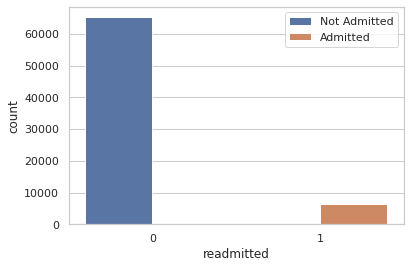

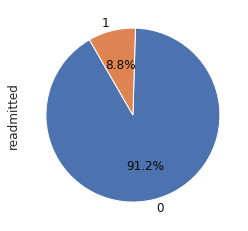

In [ ]:

##  
plt.figure()
sns.set_theme(style="whitegrid")
ax = sns.countplot(x = 'readmitted', data = data, hue = 'readmitted')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels = ['Not Admitted', 'Admitted'])
plt.figure()
data.readmitted.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'})

In [ ]:
#categorical_columns = list(data.loc[(data.loc[:,"Variable_Structure"]=="nominal")].index)
#len(categorical_columns), categorical_columns

#numerical_columns = list(data.loc[(data.loc[:,"Variable_Structure"]=="numeric")].index)
#len(numerical_columns), numerical_columns

#f,ax = plt.subplots(figsize=(8, 6))
#sns.heatmap(data[numerical_columns].corr(), annot=True, linewidths=0.5,linecolor="black", fmt= '.2f',ax=ax,cmap="coolwarm")
#plt.show()

In [ ]:
data.drop(['encounter_id', 'patient_nbr'], axis = 1, inplace = True)
data.drop(data[data.gender == 'Unknown/Invalid'].index, inplace = True)

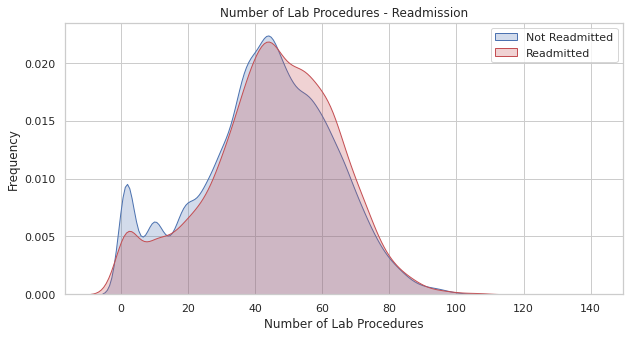

In [ ]:
fig = plt.figure(figsize=(10,5))

#readmitted = 0
ax = sns.kdeplot(data.loc[(data.readmitted == 0), "num_lab_procedures"],
                 color = "b", shade = True,label = "Not Readmitted")

#readmitted = 1
ax = sns.kdeplot(data.loc[(data.readmitted == 1), "num_lab_procedures"],
                 color = "r", shade = True, label = "Readmitted")

ax.legend(loc="upper right")

ax.set_xlabel("Number of Lab Procedures")
ax.set_ylabel("Frequency")
ax.set_title("Number of Lab Procedures - Readmission")

plt.show()

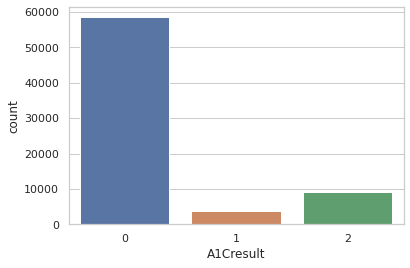

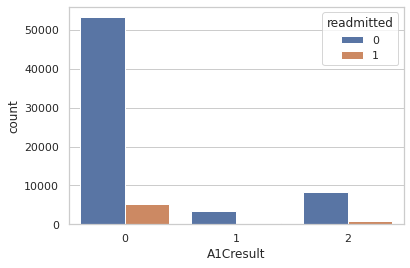

0    58529
2     9195
1     3791
Name: A1Cresult, dtype: int64


In [ ]:
data["A1Cresult"] = data["A1Cresult"].replace({">7":2,
                                           ">8":2,
                                           "Norm":1,
                                           "None":0})

sns.countplot(x = "A1Cresult", data = data)
plt.show()

sns.countplot(x = "A1Cresult",hue = "readmitted", data = data)
plt.show()

print(data.A1Cresult.value_counts())

In [ ]:
### lets analyse numeric features 
from tqdm import tqdm

data['health_index'] = data.apply(lambda x:  1 / (x['number_emergency'] + x['number_inpatient'] + x['number_outpatient'])
                                  if x['number_emergency'] != 0 or x['number_inpatient'] != 0 or x['number_outpatient'] != 0
                                  else 1, axis = 1)



total = data['time_in_hospital'].sum() + data['num_procedures'].sum() + \
                              data['num_medications'].sum() + data['num_lab_procedures'].sum() + \
                              data['number_diagnoses'].sum()

data['severity_of_disease'] = (data['time_in_hospital'] + data['num_procedures'] + \
                              data['num_medications'] + data['num_lab_procedures'] + \
                              data['number_diagnoses']) / total

drugList = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',\
            'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',\
            'troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin',\
            'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']


number_of_changes = []
for i in tqdm(range(len(data))) :
    changeCount = 0
    for col in drugList : 
        if data.iloc[i][col] in ['Down', 'Up'] :
            changeCount += 1
    number_of_changes.append(changeCount)

data['number_of_changes'] = number_of_changes

100%|██████████| 71515/71515 [05:10<00:00, 230.61it/s]


In [ ]:
data.drop(['weight', 'payer_code'], axis = 1, inplace = True)   ## change here

In [ ]:
data['discharge_disposition_id'] = data['discharge_disposition_id'].apply(lambda x : 1 if int(x) in [6, 8, 9, 13] 
                                                                           else ( 2 if int(x) in [3, 4, 5, 14, 22, 23, 24]
                                                                           else ( 10 if int(x) in [12, 15, 16, 17]
                                                                           else ( 11 if int(x) in [19, 20, 21]
                                                                           else ( 18 if int(x) in [25, 26] 
                                                                           else int(x) )))))

data = data[~data.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [ ]:
data['admission_type_id'] = data['admission_type_id'].apply(lambda x : 1 if int(x) in [2, 7]
                                                            else ( 5 if int(x) in [6, 8]
                                                            else int(x) ))

In [ ]:
data['admission_source_id'] = data['admission_source_id'].apply(lambda x : 1 if int(x) in [2, 3]
                                                            else ( 4 if int(x) in [5, 6, 10, 22, 25]
                                                            else ( 9 if int(x) in [15, 17, 20, 21]
                                                            else ( 11 if int(x) in [13, 14]
                                                            else int(x) ))))

In [ ]:
data['max_glu_serum'] = data['max_glu_serum'].apply(lambda x : 200 if x == '>200' 
                                                            else ( 300 if x == '>300'                                                          
                                                            else ( 100 if x == 'Norm'
                                                            else  0)))

In [ ]:
data['A1Cresult'] = data['A1Cresult'].apply(lambda x : 7 if x == '>7' 
                                                         else (8 if  x == '>8'                                                        
                                                         else ( 5 if x == 'Norm'
                                                         else  0)))

In [ ]:
for col in ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]:
    data[col] = data[col].apply(lambda x : 10 if x == 'Up' 
                                              else ( -10 if x == 'Down'                                                          
                                              else ( 0 if x == 'Steady'
                                              else  -20)))


data['change'] = data['change'].apply(lambda x : 1 if x == 'Ch'
                                                 else -1)


data['diabetesMed'] = data['diabetesMed'].apply(lambda x : -1 if x == 'No'
                                                else 1)

In [ ]:
data_checkpoint = data.copy()     ### saving the data to avoid redoing things again and again

In [ ]:
data = data_checkpoint.copy()
race = data['race'] 
data.drop(['race'], axis = 1, inplace = True)

In [ ]:
numeric_features = ['age','time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
                    'health_index', 'severity_of_disease', 'number_of_changes', 'A1Cresult', 'max_glu_serum', 
                    'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',\
            'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',\
            'troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin',\
            'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone', 'change', 'diabetesMed']


categorical_features = []
rejected_features = []

for col in data.columns :
    if col not in numeric_features :
        categorical_features.append(col)

for col in categorical_features : 
    data_crosstab = pd.crosstab(data['readmitted'],  
                                data[col], 
                                margins = False) 

    stat, p, dof, expected = scipy.stats.chi2_contingency(data_crosstab)
    if p < 0.4 :
	    print(p, col, 'is significant')
    else:
        print(p, col, 'is not significant')
        rejected_features.append(col)

#rejected_features.remove('admission_type_id')
print('\n\n', rejected_features)
data.drop(rejected_features, axis = 1, inplace = True)

0.5649365136977416 gender is not significant
0.018235268523518786 admission_type_id is significant
1.7670702961635e-182 discharge_disposition_id is significant
0.14913091739439216 admission_source_id is significant
1.6017605412957235e-06 medical_specialty is significant
7.047139731365279e-16 diag_1 is significant
7.047139731365279e-16 diag_2 is significant
1.8929103548343518e-07 diag_3 is significant
0.0 readmitted is significant


 ['gender']


In [ ]:
rejected_features = []
for col in numeric_features :
    rho , pval = scipy.stats.spearmanr(data['readmitted'], data[col])
    print(col, rho, pval)
    

print('\n\n')
for col in numeric_features :
    rho , pval = scipy.stats.spearmanr(data['readmitted'], data[col])
    if pval < 0.4 : 
        print(col, 'is significant')
    else : 
        print(col, 'is not significant')
        rejected_features.append(col)

#rejected_features.remove('max_glu_serum')
#rejected_features.remove('A1Cresult')
print(rejected_features)
## lets remove rejected_features
data.drop(rejected_features, axis = 1, inplace=True)

age 0.04699517679216786 9.763088866595248e-36
time_in_hospital 0.05865854050984207 9.88788178411997e-55
num_lab_procedures 0.03205313657980457 1.7609829498436774e-17
num_procedures 0.0037141294409280727 0.32429372315318505
num_medications 0.042222285096625414 3.6376441367407055e-29
number_outpatient 0.01601746179619878 2.127747332310953e-05
number_emergency 0.030398363931386705 7.082148759492669e-16
number_inpatient 0.08473011804528006 2.282652550803581e-112
number_diagnoses 0.041698289703234574 1.7372423993096614e-28
health_index -0.059116808233520196 1.4569669084834509e-55
severity_of_disease 0.04806287810890338 2.6561107236329494e-37
number_of_changes 0.023429199496016746 5.016715550160748e-10
A1Cresult nan nan
max_glu_serum 0.009266702006536386 0.013921431822441098
metformin -0.012307695913182955 0.0010892989066281955
repaglinide 0.013893369427945397 0.0002266892755126597
nateglinide -0.0036143033427687714 0.33746793782562867
chlorpropamide -0.005245021489876711 0.16393672122556519

In [ ]:
cat_new = []
for col in categorical_features :
    if col in data.columns :
        print(col, '-->', np.unique(data[col]), '\n')
        cat_new.append(col)

numeric_features = []

for col in data.columns :
    if col  not in cat_new :
        numeric_features.append(col)

admission_type_id --> [1 3 4 5] 

discharge_disposition_id --> [ 1  2  7 10 18 27 28] 

admission_source_id --> [ 1  4  7  8  9 11] 

medical_specialty --> ['high_freq' 'low_freq' 'missing' 'neurology' 'pediatrics' 'psychic'
 'surgery' 'ungrouped'] 

diag_1 --> ['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 

diag_2 --> ['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 

diag_3 --> ['circulatory' 'diabetes' 'digestive' 'genitourinary' 'injury'
 'musculoskeletal' 'neoplasms' 'other' 'pregnecy' 'respiratory'] 

readmitted --> [0 1] 



In [ ]:
data.shape

(70431, 31)

In [ ]:

from sklearn import preprocessing

#data2 = data.copy()
data2 = data.copy()
data2 = pd.get_dummies(data2, columns = cat_new)
data2['race'] = race
#data2['readmitted'] = Y
data2.dropna(inplace = True)
data_trainn = data2[data2['race'] != '?']
data_testt = data2[data2['race'] == '?']

for col in numeric_features : 
    if col in data_trainn.columns :
        scalar = StandardScaler()
        scalar = scalar.fit(np.array(data_trainn[col]).reshape(-1, 1))
        col_train = scalar.transform(np.array(data_trainn[col]).reshape(-1, 1))
        col_test = scalar.transform(np.array(data_testt[col]).reshape(-1, 1))
        data_trainn[col] = col_train.flatten()
        data_testt[col] = col_test.flatten()


le = preprocessing.LabelEncoder()
oversample = RandomOverSampler(random_state = 12)
data_trainn['race'] = le.fit_transform(data_trainn['race'])
y = data_trainn['race']
data_trainn.drop(['race'], axis = 1, inplace = True)
data_testt.drop(['race'], axis = 1, inplace = True)
data2.drop(['race'], inplace = True, axis = 1)
x_train_race, x_test_race, y_train_race, y_test_race = train_test_split(data_trainn, y, stratify = y, test_size = 0.1)
x_train_race, y_train_race = oversample.fit_resample(x_train_race, y_train_race)

In [ ]:
print(Counter(y))
print(np.unique(y))

Counter({2: 52663, 0: 12692, 3: 1506, 4: 1160, 1: 491})
[0 1 2 3 4]


In [ ]:
cat_new.remove('readmitted')

In [ ]:
data_brand_new = data.copy()
data_brand_new = pd.get_dummies(data_brand_new, columns = cat_new )  
Y = data_brand_new.readmitted
data_brand_new.drop(['readmitted'], axis = 1, inplace = True)
x_train, x_test_lr, y_train, y_test_lr = train_test_split(data_brand_new, Y, stratify = Y, test_size = 0.2, random_state = 24)

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test_lr = scaler.transform(x_test_lr)
x_train = pd.DataFrame(x_train)
x_test_lr = pd.DataFrame(x_test_lr)
x_train.columns = data_brand_new.columns

In [ ]:
from sklearn.utils import resample

X = pd.concat([x_train, y_train], axis=1)

not_readmitted = X[X.readmitted==0]
readmitted = X[X.readmitted==1]

not_readmitted_sampled = resample(not_readmitted,
                                replace = False, 
                                n_samples = len(readmitted),
                                random_state = 42)

downsampled = pd.concat([not_readmitted_sampled, readmitted])

downsampled.readmitted.value_counts()

1.0    5034
0.0    5034
Name: readmitted, dtype: int64

In [37]:
data_train_x, data_val_x, data_train_y, data_val_y = train_test_split(x_train, y_train, random_state = 24, \
                                                                      test_size = 0.2, stratify = y_train)
oversample = RandomOverSampler(random_state = 12)
data_trainn_x, data_trainn_y = oversample.fit_resample(data_train_x, data_train_y)
data_trainn_x = pd.DataFrame(data_trainn_x)
data_trainn_x.columns = data_val_x.columns

In [38]:
from sklearn.linear_model import SGDClassifier
for C in np.linspace(0.0001, 0.03, 30) :
    lr_model = SGDClassifier(alpha = C, learning_rate = 'adaptive', loss = 'log' , penalty = 'elasticnet', \
                             random_state = 24, class_weight = 'balanced', eta0 = 0.001,
                             early_stopping = True, n_iter_no_change = 3
                              )
    lr_model.fit(data_trainn_x, data_trainn_y)
    print(C, roc_auc_score(data_val_y, lr_model.predict_proba(data_val_x)[:, 1]))

0.0001 0.6219279311047575
0.0011310344827586208 0.6220265392302605
0.0021620689655172413 0.6219486397788082
0.0031931034482758623 0.6219879281978015
0.004224137931034483 0.6219368338992092
0.005255172413793104 0.6218839977495284
0.006286206896551725 0.6216918135127776
0.007317241379310346 0.6216957810624789
0.008348275862068965 0.6216116883627122
0.009379310344827587 0.6214749530522747
0.010410344827586206 0.6214398257219924
0.011441379310344828 0.6215154027053269
0.01247241379310345 0.6215933021567793
0.013503448275862069 0.6214829849211821
0.01453448275862069 0.6213988922214155
0.01556551724137931 0.6213869895723118
0.01659655172413793 0.6213940537461701
0.017627586206896553 0.6213952149802291
0.018658620689655174 0.621389989426964
0.019689655172413792 0.6213919248170622
0.020720689655172413 0.6213742159976636
0.021751724137931035 0.621350313929951
0.022782758620689656 0.621331927724018
0.023813793103448277 0.6213183799933307
0.0248448275862069 0.6212989293228437
0.025875862068965517

In [39]:
lr_model = SGDClassifier(alpha = 0.004224137931034483, learning_rate = 'adaptive', loss = 'log' , penalty = 'elasticnet', \
                             random_state = 24, class_weight = 'balanced', eta0 = 0.001,
                             early_stopping = True, n_iter_no_change = 3
                              )
lr_model.fit(data_trainn_x, data_trainn_y)
predicted_prob = lr_model.predict_proba(x_test_lr)[:, 1]
predicted = lr_model.predict(x_test_lr)
AUC_LR = roc_auc_score(y_test_lr, predicted_prob)
print('AUC_LR = ', AUC_LR)
f1_pos = f1_score(y_test_lr, predicted)
f1_neg = f1_score([0 if x == 1 else 1 for x in y_test_lr], [0 if x == 1 else 1 for x in predicted])
print('F1_POS = ', f1_pos, 'F1_NEG = ', f1_neg)
HARMONIC_F1_LR = ((2 * f1_pos * f1_neg) / (f1_neg + f1_pos))
print('HARMONIC_F1_LR = ', HARMONIC_F1_LR)

AUC_LR =  0.6502401914200295
F1_POS =  0.22550335570469798 F1_NEG =  0.7922031151526063
HARMONIC_F1_LR =  0.351072663842139


Roc_auc_score for Logistic Regression With SGD:  0.6502401914200295


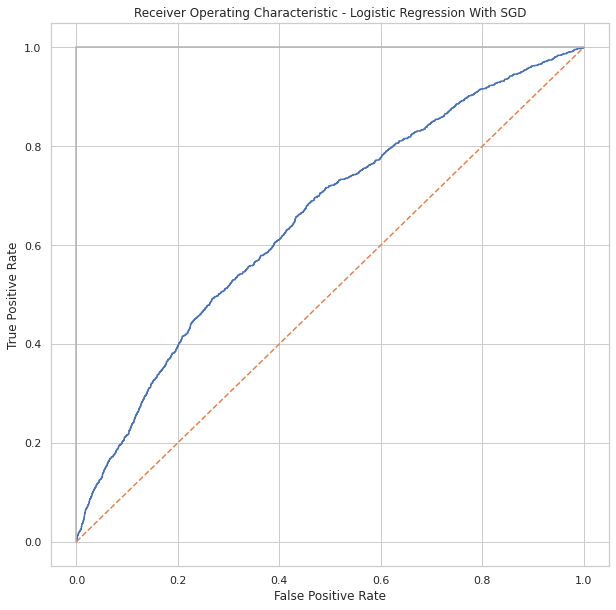

In [40]:
y_score2 = lr_model.predict_proba(x_test_lr)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test_lr, y_score2)
print('Roc_auc_score for Logistic Regression With SGD: ', roc_auc_score(y_test_lr, y_score2))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic Regression With SGD')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [41]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(solver = "liblinear",class_weight="balanced",random_state = 42).fit(data_trainn_x, data_trainn_y)

In [42]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import confusion_matrix as cm
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    fscore = f1_score(y_actual,(y_pred > thresh) )
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('fscore:%.3f'%fscore)
    print('specificity:%.3f'%specificity)
    print(' ')
    return auc, accuracy, recall, precision,fscore, specificity

In [43]:
thresh = 0.5
y_train_preds = log_model.predict_proba(data_trainn_x)[:,1]
y_val_preds = log_model.predict_proba(data_val_x)[:,1]

print("Logistic Regression")
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_fscore, lr_train_specificity = print_report(data_trainn_y,y_train_preds, thresh)
print('Validation:')
lr_val_auc, lr_val_accuracy, lr_val_recall, \
    lr_val_precision,lr_val_fscore, lr_val_specificity = print_report(data_val_y,y_val_preds, thresh)



Logistic Regression
Training:
AUC:0.645
accuracy:0.606
recall:0.531
precision:0.625
fscore:0.574
specificity:0.682
 
Validation:
AUC:0.623
accuracy:0.662
recall:0.509
precision:0.134
fscore:0.212
specificity:0.677
 


Roc_auc_score for Logistic Regression(Baseline):  0.6227709870315316


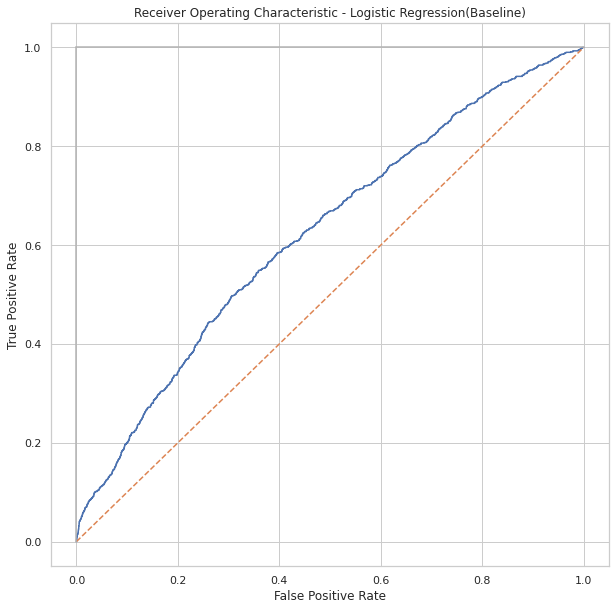

In [44]:
y_score2 = log_model.predict_proba(data_val_x)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(data_val_y, y_score2)
print('Roc_auc_score for Logistic Regression(Baseline): ', roc_auc_score(data_val_y, y_score2))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic Regression(Baseline)')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

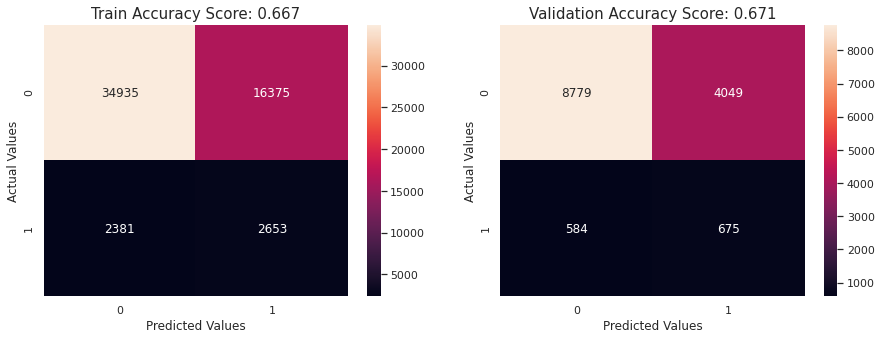

In [45]:


predictions = log_model.predict(x_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = cm(y_train, predictions)

predictions = log_model.predict(x_test_lr)
val_score = round(accuracy_score(y_test_lr, predictions), 3)
cm_val = cm(y_test_lr, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Train Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

In [46]:
y_p=[]
for i in range(y_test_lr.shape[0]):
    y_p.append(y_test_lr.mode()[0])#Highest class is assigned to a list which is compared with ytest
len(y_p) 

14087

In [47]:
y_pred=pd.Series(y_p)

In [48]:
print("Accuracy : ",accuracy_score(y_test_lr,y_pred))

Accuracy :  0.9106268190530277


Training Accuracy : 1.0
Testing Accuracy : 0.8285653439341236
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     12828
           1       0.12      0.15      0.13      1259

    accuracy                           0.83     14087
   macro avg       0.52      0.52      0.52     14087
weighted avg       0.84      0.83      0.84     14087

roc_auc_score for Decision tree:  0.5215606968770905


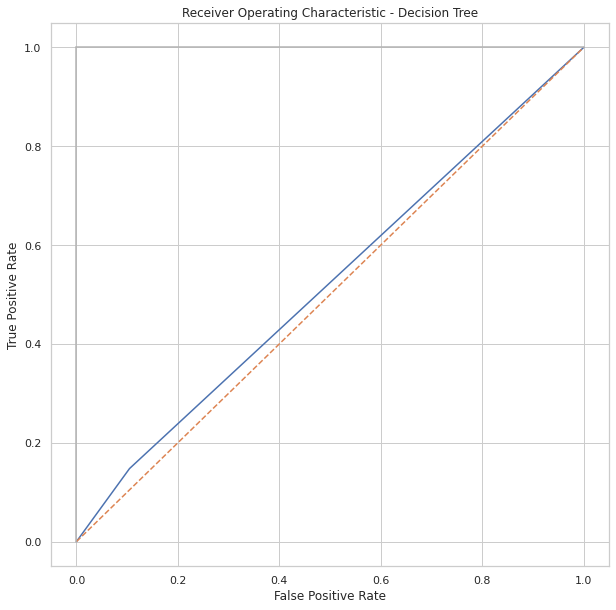

In [49]:


from sklearn.tree import DecisionTreeClassifier
m4 = DecisionTreeClassifier()
m4.fit(x_train,y_train)
y_pred_dt=m4.predict(x_test_lr)
Train_Score_dt = m4.score(x_train,y_train)
Test_Score_dt = accuracy_score(y_test_lr,y_pred_dt)

print('Training Accuracy :',Train_Score_dt)
print('Testing Accuracy :',Test_Score_dt)
print(classification_report(y_test_lr,y_pred_dt))



y_score2 = m4.predict_proba(x_test_lr)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test_lr, y_score2)
print('roc_auc_score for Decision tree: ', roc_auc_score(y_test_lr, y_score2))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


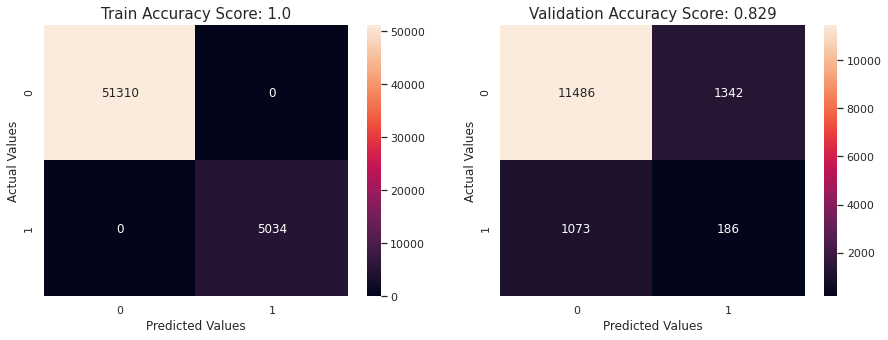

In [50]:
predictions = m4.predict(x_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = cm(y_train, predictions)

predictions = m4.predict(x_test_lr)
val_score = round(accuracy_score(y_test_lr, predictions), 3)
cm_val = cm(y_test_lr, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Train Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

Training Accuracy : 1.0
Testing Accuracy : 0.9106268190530277
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     12828
           1       0.50      0.00      0.00      1259

    accuracy                           0.91     14087
   macro avg       0.71      0.50      0.48     14087
weighted avg       0.87      0.91      0.87     14087

roc_auc_score for Random Forest:  0.6223780609979214


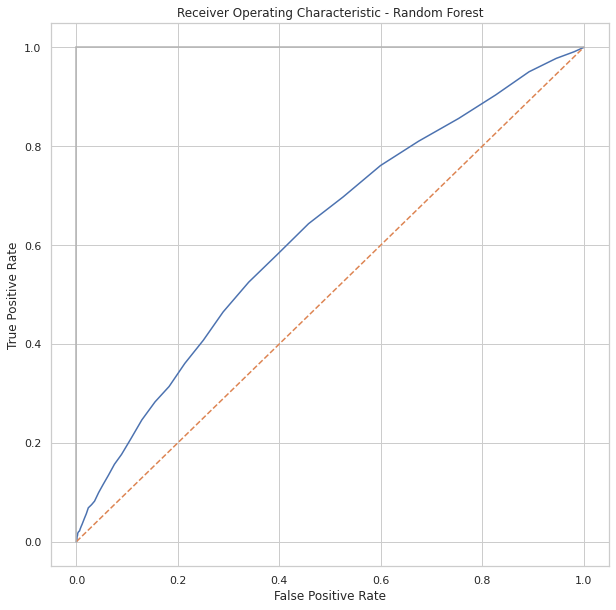

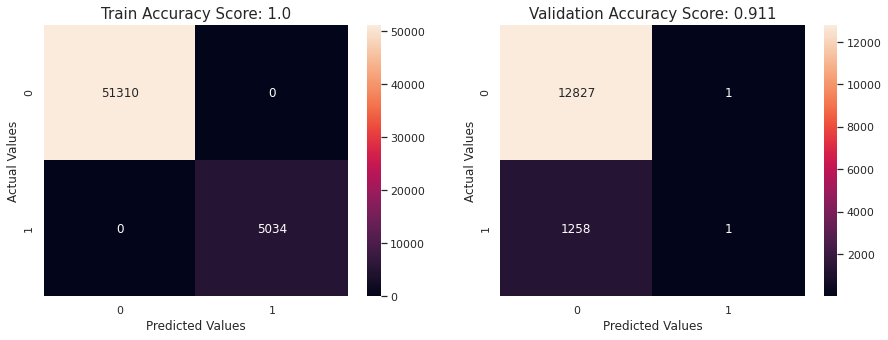

In [51]:
m5 = RandomForestClassifier()
m5.fit(x_train,y_train)
y_pred_rf=m5.predict(x_test_lr)
Train_Score_rf = m5.score(x_train,y_train)
Test_Score_rf = accuracy_score(y_test_lr,y_pred_rf)

print('Training Accuracy :',Train_Score_rf)
print('Testing Accuracy :',Test_Score_rf)
print(classification_report(y_test_lr,y_pred_rf))

y_score2 = m5.predict_proba(x_test_lr)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test_lr, y_score2)
print('roc_auc_score for Random Forest: ', roc_auc_score(y_test_lr, y_score2))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

predictions = m5.predict(x_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = cm(y_train, predictions)

predictions = m5.predict(x_test_lr)
val_score = round(accuracy_score(y_test_lr, predictions), 3)
cm_val = cm(y_test_lr, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Train Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

In [52]:
y_train_preds = m5.predict_proba(x_train)[:,1]
y_val_preds = m5.predict_proba(x_test_lr)[:,1]

print("Random Forest")
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision,rf_train_fscore, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_val_auc, rf_val_accuracy, rf_val_recall, rf_val_precision,rf_val_fscore, rf_val_specificity = print_report(y_test_lr,y_val_preds, thresh)

Random Forest
Training:
AUC:1.000
accuracy:1.000
recall:1.000
precision:1.000
fscore:1.000
specificity:1.000
 
Validation:
AUC:0.622
accuracy:0.911
recall:0.001
precision:0.500
fscore:0.002
specificity:1.000
 


In [53]:
#from sklearn.preprocessing import MinMaxScaler
#scaling = MinMaxScaler(feature_range=(-1,1)).fit(data_trainn_x)
#data_trainn_x = scaling.transform(data_trainn_x)
#data_val_x = scaling.transform(data_val_x)

Training Accuracy : 0.599578542194504
Testing Accuracy  : 0.625432602715414
              precision    recall  f1-score   support

           0       0.93      0.63      0.75     10262
           1       0.13      0.55      0.21      1007

    accuracy                           0.63     11269
   macro avg       0.53      0.59      0.48     11269
weighted avg       0.86      0.63      0.71     11269

roc_auc_score for Naive Bayes:  0.6151424050357301


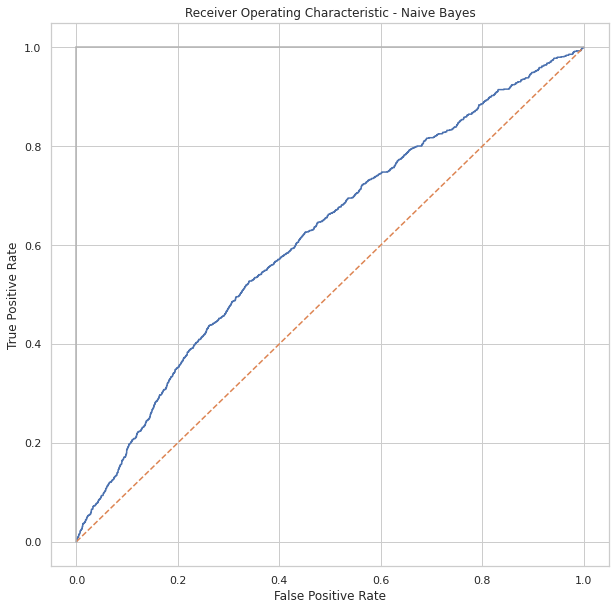

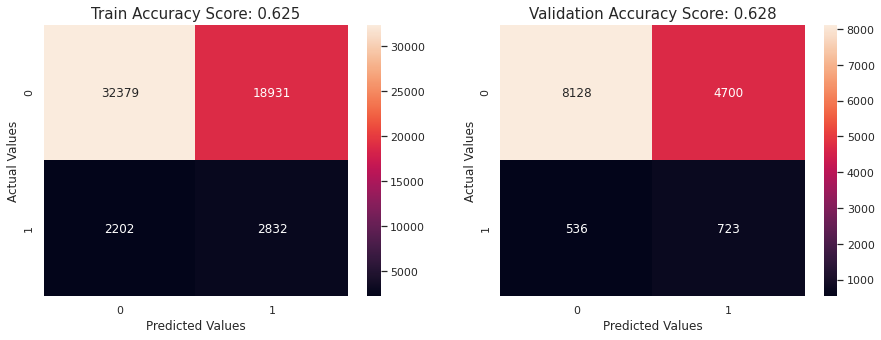

In [54]:
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
m3=BernoulliNB()
m3.fit(data_trainn_x,data_trainn_y)
y_pred_bnb=m3.predict(data_val_x)
Train_Score_bnb = m3.score(data_trainn_x,data_trainn_y)
Test_Score_bnb = accuracy_score(data_val_y,y_pred_bnb)

print('Training Accuracy :',Train_Score_bnb)
print('Testing Accuracy  :',Test_Score_bnb)
print(classification_report(data_val_y,y_pred_bnb))

y_score2 = m3.predict_proba(data_val_x)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(data_val_y, y_score2)
print('roc_auc_score for Naive Bayes: ', roc_auc_score(data_val_y, y_score2))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Naive Bayes')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


predictions = m3.predict(x_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = cm(y_train, predictions)

predictions = m3.predict(x_test_lr)
val_score = round(accuracy_score(y_test_lr, predictions), 3)
cm_val = cm(y_test_lr, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Train Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

Training Accuracy : 0.9106559704671305
Testing Accuracy : 0.9106268190530277
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     12828
           1       0.00      0.00      0.00      1259

    accuracy                           0.91     14087
   macro avg       0.46      0.50      0.48     14087
weighted avg       0.83      0.91      0.87     14087



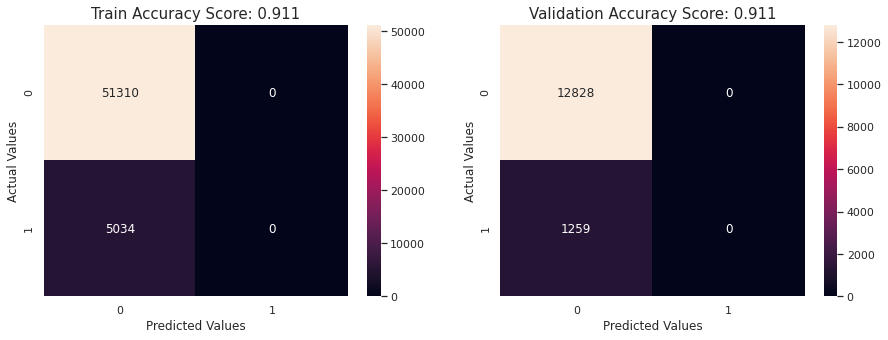

In [55]:
#x_train, x_test_lr, y_train, y_test_lr 
from sklearn import svm # "Support vector classifier"
m9 = svm.SVC(kernel='linear', C=1.0, gamma=0.1)
m9.fit(x_train, y_train)
#m9=svm.SVC()

y_pred_S = m9.predict(x_test_lr)

#Import scikit-learn metrics module for accuracy calculation
Train_Score_svm = m9.score(x_train,y_train)
Test_Score_svm = accuracy_score(y_test_lr,y_pred_S)

print('Training Accuracy :',Train_Score_svm)
print('Testing Accuracy :',Test_Score_svm)
print(classification_report(y_test_lr,y_pred_S))


predictions = m9.predict(x_train)
train_score = round(accuracy_score(y_train, predictions), 3)
cm_train = cm(y_train, predictions)

predictions = m9.predict(x_test_lr)
val_score = round(accuracy_score(y_test_lr, predictions), 3)
cm_val = cm(y_test_lr, predictions)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5)) 
sns.heatmap(cm_train, annot=True, fmt=".0f",ax=ax1)
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Actual Values')
ax1.set_title('Train Accuracy Score: {0}'.format(train_score), size = 15)
sns.heatmap(cm_val, annot=True, fmt=".0f",ax=ax2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.set_title('Validation Accuracy Score: {0}'.format(val_score), size = 15)
plt.show()

In [ ]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

x_train, x_test_lr, y_train, y_test_lr
#Gridsearch CV to find Optimal K value for KNN model
grid = {'n_neighbors':np.arange(1,10)}
knn=KNeighborsClassifier()
knn_cv=GridSearchCV(knn,grid,cv=3)
knn_cv.fit(x_train,y_train)

print("Tuned Hyperparameter k: {}".format(knn_cv.best_params_))

In [58]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

parameter={'n_estimators':np.arange(1,101)}
gs = GridSearchCV(m5,parameter,cv=3)
gs.fit(data_trainn_x,data_trainn_y)
gs.best_params_

{'n_estimators': 74}

In [59]:
rf = RandomForestClassifier()
rf_params = {"max_depth": [2,5,8],
             "n_estimators": [100,200,500,700],
             "max_features": [3,5,8],
             "min_samples_split":[2,5,10]}

In [60]:
rf_cv_model = GridSearchCV(rf, rf_params, cv=3, n_jobs=-1, verbose=2).fit(X_train_importance, y_train)
max_depth=5,
                                 max_features=5,
                                 min_samples_split=5,
                                 n_estimators=500


IndentationError: ignored

In [ ]:
m10 = RandomForestClassifier(n_estimators=98)
m10.fit(x_train,y_train) 
y_pred_trf=m10.predict(x_test_lr)
Train_Score_trf = m10.score(x_train,y_train)
Test_Score_trf = accuracy_score(y_train,y_pred_trf)

print('Training Accuracy :',Train_Score_trf)
print('Testing Accuracy  :',Test_Score_trf)
print(classification_report(y_train,y_pred_trf))

y_score2 = m10.predict_proba(x_test_lr)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_train, y_score2)
print('roc_auc_score for Random forest(Optimized): ', roc_auc_score(y_train, y_score2))


In [ ]:
#x_train, x_test_lr, y_train, y_test_lr

m8 = RandomForestClassifier(n_estimators=100)
m8.fit(x_train,y_train) 
y_pred_trf=m8.predict(x_test_lr)
Train_Score_trf = m8.score(x_train,y_train)
Test_Score_trf = accuracy_score(y_train,y_pred_trf)


print('Training Accuracy :',Train_Score_trf)
print('Testing Accuracy  :',Test_Score_trf)
print(classification_report(y_train,y_pred_trf))

y_score2 = m8.predict_proba(x_test_lr)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_train, y_score2)
print('roc_auc_score for Random forest: ', roc_auc_score(y_train, y_score2))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from lightgbm import LGBMClassifier
lgbm_model = LGBMClassifier(random_state = 42,max_depth=3)
lgbm_model.fit(x_train, y_train)

In [ ]:
import lightgbm as lgb

#x_train, x_test_lr, y_train, y_test_lr

plt.rcParams["figure.figsize"] = (18, 10)
lgb.plot_importance(lgbm_model)

feature_imp = pd.Series(lgbm_model.feature_importances_, index = x_train.columns)
best_features = feature_imp.nlargest(25)

X_train_importance = x_train[best_features.index]
X_test_importance = x_test_lr[best_features.index]

In [ ]:
y_train_preds = lgbm_model.predict_proba(data_trainn_x)[:,1]
y_val_preds = lgbm_model.predict_proba(data_val_x)[:,1]

print("LGBM")
print('Training:')
lgbm_train_auc, lgbm_train_accuracy,lgbm_train_recall, lgbm_train_precision,lgbm_train_fscore,lgbm_train_specificity = print_report(data_trainn_y,y_train_preds, thresh)
print('Validation:')
lgbm_val_auc, lgbm_val_accuracy, lgbm_val_recall, lgbm_val_precision,lgbm_val_fscore,lgbm_val_specificity = print_report(y_val,y_val_preds, thresh)

In [ ]:
classifiers = [ m4,
                m5]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    yproba = cls.predict_proba(X_test_importance)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
result_table.sort_values('auc',ascending=False,inplace=True)

In [ ]:
fig = plt.figure(figsize=(10,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='black', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=14)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=14)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':10}, loc='lower right')

plt.show()

In [ ]:
Model_Scores=pd.DataFrame({'Models':['Logistic Regression','KNN','Bernoulli Naives Bayes','SVM','Decision Tree','Random Forest'],
             'Training Accuracy':[lr_train_accuracy,Train_Score_knn,Train_Score_bnb,Train_Score_svm,Train_Score_dt,Train_Score_rf],
             'Testing Accuracy':[lr_val_accuracy,Test_Score_knn,Test_Score_bnb,Test_Score_svm,Test_Score_dt,Test_Score_rf],
                })

Model_Scores.sort_values(by=('Testing Accuracy'),ascending=False)